In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
from Simulation import *

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

In [2]:
# Aspen connection
cwd = os.getcwd()
sim = Simulation("ORC.bkp", cwd)

# Molecular weights

MW = {
    "BUTANE": 58.12,
    "PENTANE": 72.15,
    "ISOBUT": 58.12,
    "ISOPEN": 72.15,
}

GWP = {
    "BUTANE": 4,
    "PENTANE": 5,
    "ISOBUT": 3,
    "ISOPEN": 5,
}

class MyProblem(ElementwiseProblem):

    def __init__(self, aspen):
        super(MyProblem, self).__init__(n_var=5, n_obj=2, n_ieq_constr=1,
            xl=np.zeros((5, ), dtype=np.float32), 
            xu=np.array([1,1,1,1,10], dtype=np.float32))
        
        self.aspen = aspen

    def _evaluate(self, x, out, *args, **kwargs):

        # Inlet composition
        inlet_comp = {
            "BUTANE": x[0],
            "PENTANE": x[1],
            "ISOBUT": x[2],
            "ISOPEN": x[3],
        }

        inlet_flow = [25.0, 1.0, inlet_comp]

        s1 = Stream(inlet_flow)
        pump = Pump(x[4])
        turb = Turbine()
        boiler = Boiler()
        cond = Condenser()

        self.aspen.EngineRun()

        # Constraint

        g1 = (sum(x[:4]) - 1)**2 - 1e-10

        # Objective 1 - Efficiency (maximize)
        qin = boiler.enery_consumption()
        wout = turb.enery_consumption()
        win = pump.enery_consumption()
        eff = - (np.abs(wout - win)/qin)

        # Objective 2 - Environmental impact (minimize)
        env = sum(MW[compound] * GWP[compound] * inlet_comp[compound] for compound in MW.keys())
        

        
        out["F"] = [eff, env]
        out["G"] = [g1]

problem = MyProblem(aspen=sim)


algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)


termination = get_termination("n_gen", 150)


res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)


sim.CloseAspen()

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       40 |      1 |  0.0004379395 |  1.1970518568 |             - |             -
     2 |       50 |      1 |  0.0004379395 |  0.6453989786 |             - |             -
     3 |       60 |      1 |  0.0000149157 |  0.3924595522 |             - |             -
     4 |       70 |      1 |  0.0000149157 |  0.2330476030 |             - |             -
     5 |       80 |      1 |  0.0000149157 |  0.1486621247 |             - |             -
     6 |       90 |      1 |  0.0000149157 |  0.0789159432 |             - |             -
     7 |      100 |      1 |  0.0000149157 |  0.0293906573 |             - |             -
     8 |      110 |      1 |  0.0000149157 |  0.0144189248 |             - |             -
     9 |      120 |      1 |  0.0000149157 |  0.0089924954 |             - |             -
    10 |      130 |      1 |  0.0000103792 |  0.0054191036 |             - |             -

In [3]:
X = res.X
F = res.F
print(F)
print(X)

[[-8.39249674e-02  2.87629657e+02]
 [-8.39249795e-02  2.87630329e+02]
 [-8.39249699e-02  2.87629673e+02]
 [-8.39249633e-02  2.87629564e+02]
 [-8.39249734e-02  2.87630249e+02]
 [-8.39249747e-02  2.87630322e+02]
 [-8.39249715e-02  2.87630137e+02]
 [-8.39249714e-02  2.87630132e+02]
 [-8.39249731e-02  2.87630195e+02]
 [-8.39249700e-02  2.87630070e+02]
 [-8.39249745e-02  2.87630313e+02]
 [-8.39249733e-02  2.87630238e+02]
 [-8.39249451e-02  2.87628450e+02]
 [-8.39249709e-02  2.87630078e+02]
 [-8.39249740e-02  2.87630283e+02]
 [-8.39249739e-02  2.87630265e+02]
 [-8.39249752e-02  2.87630324e+02]
 [-8.39249619e-02  2.87629364e+02]
 [-8.39249719e-02  2.87630194e+02]
 [-8.39249442e-02  2.87628437e+02]
 [-8.39249718e-02  2.87630150e+02]
 [-8.39249744e-02  2.87630288e+02]
 [-8.39249453e-02  2.87628539e+02]
 [-8.39249657e-02  2.87629582e+02]
 [-8.39249584e-02  2.87629332e+02]
 [-8.39249748e-02  2.87630323e+02]
 [-8.39249430e-02  2.87628367e+02]
 [-8.39249743e-02  2.87630287e+02]
 [-8.39249600e-02  2

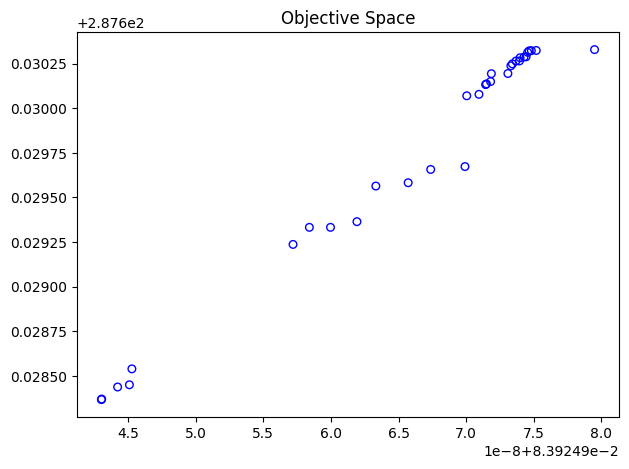

In [5]:
plt.figure(figsize=(7, 5))
plt.scatter(-F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()